In [ ]:
import pandas as pd
import seaborn as sns
import json
import urllib.request
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
with open(r"words.txt", encoding="utf-8") as f:
    wordle_script = f.read()

raw_words = wordle_script.split(',')
wordle_words = []
for raw_word in raw_words:
    word = raw_word.strip('"')
    wordle_words.append(word)

curated_words = wordle_words[:2315]

with open(r'wordle_words.json', 'w') as outfile:
    json.dump(wordle_words, outfile)

In [ ]:
# Word list with frequency from Google
flw_with_freq = []  # flw = five letter words
for line in urllib.request.urlopen(r'http://norvig.com/google-books-common-words.txt'):
    line = (line.decode('utf-8')).split('\t')
    word = line[0].lower()
    freq = line[1].split('\n')[0]
    if len(word) == 5:
        flw_with_freq.append((word, freq))

In [ ]:
w = pd.DataFrame(wordle_words, columns=['w'])
w['in_wordle'] = w['w'].apply(lambda x: x in wordle_words)
w['in_wordle_curated'] = w['w'].apply(lambda x: x in curated_words)
flwfreqdf = pd.DataFrame(flw_with_freq, columns=['w', 'freq'])
w = w.merge(right=flwfreqdf, left_on='w', right_on='w', how='outer')
w.loc[:, ['in_wordle', 'in_wordle_curated']] = w.loc[:, ['in_wordle', 'in_wordle_curated']].replace(np.nan, False)
w.set_index('w', inplace=True)
w['freq'] = w['freq'].astype('float64')
w.to_csv(r'wordle_google_freq_word_list.csv')
w

In [ ]:
alphabet = 'abcdefghijklmnopqrstuvwxyz'

def make_bow(word_list):
    # bow = Bag Of Words
    bow = {i: {letter: 0 for letter in alphabet} for i in range(5)}
    for char in range(5):
        for word in word_list:
            bow[char][word[char]] += 1
    # normalize each count by dividing by len(word_list)
    for i in bow:
        for char in bow[i]:
            bow[i][char] = bow[i][char]/len(word_list)
    return bow

In [ ]:
bow_17k = make_bow(w.index.to_list())
bow_all_wordle = make_bow(w.loc[w['in_wordle']].index.to_list())
bow_curated_wordle = make_bow(w.loc[w['in_wordle_curated']].index.to_list())
all_bow = {'combined_wordle_google': bow_17k, 'all_wordle': bow_all_wordle, 'wordle_curated': bow_curated_wordle}

with open(r'bags_of_words.json', 'w') as outfile:
    json.dump(all_bow, outfile)

In [ ]:
def calc_lfl(word_list, bow, colname):
    """    
    Calculate Likelihood of word from Letter Frequency given in a bag of words 5x26 matrix 
        see BJA-01.2-make-word-lists
    """
    result = []
    for word in word_list:
        likelihood = 1
        for i, letter in enumerate(word):
            likelihood *= bow[str(i)][letter]
        result.append((word, likelihood))
    return pd.DataFrame(sorted(result, key=lambda x: x[1], reverse=True), columns=['w', colname]).set_index('w') 

def total_green_letter_prob(word, bow=bowcur):
    # Finds total probability that you will get at least 1 green in any position by testing this word
    prob = 0
    for i, letter in enumerate(word):
        prob += bow[str(i)][letter]
    return prob

In [ ]:
# word list with frequencies
wl = pd.read_csv(r'wordle_google_freq_word_list.csv', index_col=0)
alphabet = 'abcdefghijklmnopqrstuvwxyz'
# Read in  Bags of Words matrices: 
with open(r'bags_of_words.json', 'r') as infile:
    all_bow = json.load(infile, parse_int=False)
bow17 = all_bow['combined_wordle_google']
bowwordle = all_bow['all_wordle']
bowcur = all_bow['wordle_curated']

bow17lfl = calc_lfl(wl.index, bow17, colname='all')
bowwordlelfl = calc_lfl(wl.loc[wl['in_wordle']].index, bowwordle, colname='wordle')
bowcurlfl = calc_lfl(wl.loc[wl['in_wordle_curated']].index, bowcur, colname='curated')

lfl = pd.concat([bow17lfl, bowwordlelfl, bowcurlfl], axis=1, sort=True)
# lfl.to_csv(r'..\data\processed\letter_freq_likelihoods.csv')

In [ ]:
data = wl.loc[wl['in_wordle'], ['in_wordle_curated']]
data['wp'] = calc_lfl(data.index, bowcur, colname='wp')   

# wp = Word Probability from letter frequency
# tglp = Total Green Letter Probability
# sum of all probabilities of finding that letter in that position 

data['tglp'] = data.index.map(lambda x: total_green_letter_prob(x)) 
curated_sorted = data.sort_values(['in_wordle_curated', 'tglp'], ascending=False)
curated_words = curated_sorted.loc[curated_sorted['in_wordle_curated']].index
display(curated_words)
data = data.sort_values('tglp', ascending=False)
data['unique_letters'] = data.index.map(lambda x: len(set(x)))
data.head(10)

In [ ]:
data[data['in_wordle_curated']]['unique_letters'].hist()

In [ ]:
ul = data[data['in_wordle_curated']]['unique_letters']
ul = ul.append(pd.Series({'dummy2': 1, 'dummy3': 2}))
ul.hist(bins=5, color='steelblue')
plt.title('Number of unique letters in 2315 Wordle words', fontsize=16)
plt.xticks([1.4,2.2,3,3.8, 4.6,], ['1','2','3','4','5'], fontsize=12)
plt.yticks([400,800,1200,1600],fontsize=14)
plt.grid(alpha=0.0, axis='x')

In [ ]:
sns.boxplot(x='unique_letters', 
               y='tglp',
#                scale='count',
               data=data,
#                order=['2', '3', '4', '5'], 
               orient='v')
plt.ylim((0, 0.72))
plt.annotate('n = 9', xy=(0, 0.02), fontsize=14, ha='center')
plt.annotate('n = 456', xy=(1, 0.02), fontsize=14, ha='center')
plt.annotate('n = 4185', xy=(2, 0.02), fontsize=14, ha='center')
plt.annotate('n = 8322', xy=(3, 0.02), fontsize=14, ha='center')

plt.gcf().set_size_inches((5, 5))
plt.title('Number of unique letters in 2315 words', fontsize=16)
plt.xticks(fontsize=14)
plt.xlabel('Number of unique letters in word', fontsize=16)
plt.ylabel('Total green letter probability', fontsize=16)
plt.yticks(fontsize=14)

In [14]:
# Word list with frequency from Google
flw_with_freq = []  # flw = five letter words
for line in urllib.request.urlopen(r'http://norvig.com/google-books-common-words.txt'):
    line = (line.decode('utf-8')).split('\t')
    word = line[0].lower()
    freq = line[1].split('\n')[0]
    if len(word) == 5:
        flw_with_freq.append((word, freq))

In [18]:
w = pd.DataFrame(wordle_words, columns=['w'])
w['in_wordle'] = w['w'].apply(lambda x: x in wordle_words)
w['in_wordle_curated'] = w['w'].apply(lambda x: x in curated_words)
flwfreqdf = pd.DataFrame(flw_with_freq, columns=['w', 'freq'])
w = w.merge(right=flwfreqdf, left_on='w', right_on='w', how='outer')
w.loc[:, ['in_wordle', 'in_wordle_curated']] = w.loc[:, ['in_wordle', 'in_wordle_curated']].replace(np.nan, False)
w.set_index('w', inplace=True)
w['freq'] = w['freq'].astype('float64')
w.to_csv(r'wordle_google_freq_word_list.csv')
w

,in_wordle,in_wordle_curated,freq
w,,,
cigar,True,True,3877425.0
rebut,True,True,508399.0
sissy,True,True,548761.0
humph,True,True,274977.0
awake,True,True,9037710.0
...,...,...,...
kempf,False,False,100070.0
sakha,False,False,100063.0
ekiti,False,False,100063.0


In [20]:
alphabet = 'abcdefghijklmnopqrstuvwxyz'

def make_bow(word_list):
    # bow = Bag Of Words
    bow = {i: {letter: 0 for letter in alphabet} for i in range(5)}
    for char in range(5):
        for word in word_list:
            bow[char][word[char]] += 1
    # normalize each count by dividing by len(word_list)
    for i in bow:
        for char in bow[i]:
            bow[i][char] = bow[i][char]/len(word_list)
    return bow

In [25]:
bow_17k = make_bow(w.index.to_list())
bow_all_wordle = make_bow(w.loc[w['in_wordle']].index.to_list())
bow_curated_wordle = make_bow(w.loc[w['in_wordle_curated']].index.to_list())
all_bow = {'combined_wordle_google': bow_17k, 'all_wordle': bow_all_wordle, 'wordle_curated': bow_curated_wordle}

with open(r'bags_of_words.json', 'w') as outfile:
    json.dump(all_bow, outfile)

In [30]:
def calc_lfl(word_list, bow, colname):
    """    
    Calculate Likelihood of word from Letter Frequency given in a bag of words 5x26 matrix 
        see BJA-01.2-make-word-lists
    """
    result = []
    for word in word_list:
        likelihood = 1
        for i, letter in enumerate(word):
            likelihood *= bow[str(i)][letter]
        result.append((word, likelihood))
    return pd.DataFrame(sorted(result, key=lambda x: x[1], reverse=True), columns=['w', colname]).set_index('w') 

def total_green_letter_prob(word, bow=bowcur):
    # Finds total probability that you will get at least 1 green in any position by testing this word
    prob = 0
    for i, letter in enumerate(word):
        prob += bow[str(i)][letter]
    return prob

In [28]:
# word list with frequencies
wl = pd.read_csv(r'wordle_google_freq_word_list.csv', index_col=0)
alphabet = 'abcdefghijklmnopqrstuvwxyz'
# Read in  Bags of Words matrices: 
with open(r'bags_of_words.json', 'r') as infile:
    all_bow = json.load(infile, parse_int=False)
bow17 = all_bow['combined_wordle_google']
bowwordle = all_bow['all_wordle']
bowcur = all_bow['wordle_curated']

bow17lfl = calc_lfl(wl.index, bow17, colname='all')
bowwordlelfl = calc_lfl(wl.loc[wl['in_wordle']].index, bowwordle, colname='wordle')
bowcurlfl = calc_lfl(wl.loc[wl['in_wordle_curated']].index, bowcur, colname='curated')

lfl = pd.concat([bow17lfl, bowwordlelfl, bowcurlfl], axis=1, sort=True)
# lfl.to_csv(r'..\data\processed\letter_freq_likelihoods.csv')

In [31]:
data = wl.loc[wl['in_wordle'], ['in_wordle_curated']]
data['wp'] = calc_lfl(data.index, bowcur, colname='wp')   

# wp = Word Probability from letter frequency
# tglp = Total Green Letter Probability
# sum of all probabilities of finding that letter in that position 

data['tglp'] = data.index.map(lambda x: total_green_letter_prob(x)) 
curated_sorted = data.sort_values(['in_wordle_curated', 'tglp'], ascending=False)
curated_words = curated_sorted.loc[curated_sorted['in_wordle_curated']].index
display(curated_words)
data = data.sort_values('tglp', ascending=False)
data['unique_letters'] = data.index.map(lambda x: len(set(x)))
data.head(10)

Index(['slate', 'sauce', 'slice', 'shale', 'saute', 'share', 'sooty', 'shine',
       'suite', 'crane',
       ...
       'lymph', 'jumbo', 'igloo', 'ethic', 'unzip', 'umbra', 'affix', 'ethos',
       'inbox', 'nymph'],
      dtype='object', name='w', length=2315)

,in_wordle_curated,wp,tglp,unique_letters
w,,,,
saree,False,0.000037,0.680346,4
sooey,False,0.000043,0.678618,4
soree,False,0.000034,0.669546,4
saine,False,0.000034,0.666091,5
soare,False,0.000030,0.660043,5
saice,False,0.000029,0.653132,5
sease,False,0.000030,0.652268,3
seare,False,0.000026,0.644060,4
seine,False,0.000027,0.639309,4


<AxesSubplot:>

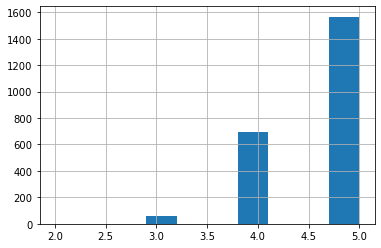

In [32]:
data[data['in_wordle_curated']]['unique_letters'].hist()

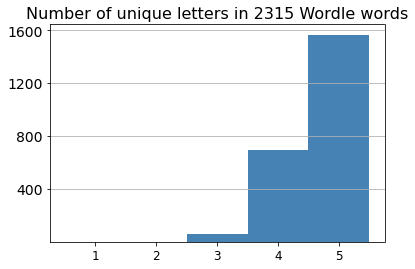

In [35]:
ul = data[data['in_wordle_curated']]['unique_letters']
ul = ul.append(pd.Series({'dummy2': 1, 'dummy3': 2}))
ul.hist(bins=5, color='steelblue')
plt.title('Number of unique letters in 2315 Wordle words', fontsize=16)
plt.xticks([1.4,2.2,3,3.8, 4.6,], ['1','2','3','4','5'], fontsize=12)
plt.yticks([400,800,1200,1600],fontsize=14)
plt.grid(alpha=0.0, axis='x')

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

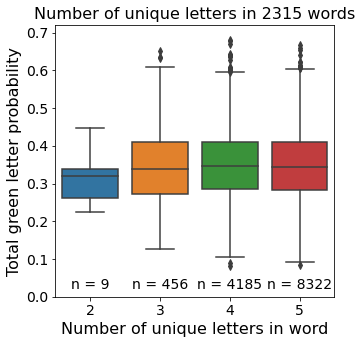

In [36]:
sns.boxplot(x='unique_letters', 
               y='tglp',
#                scale='count',
               data=data,
#                order=['2', '3', '4', '5'], 
               orient='v')
plt.ylim((0, 0.72))
plt.annotate('n = 9', xy=(0, 0.02), fontsize=14, ha='center')
plt.annotate('n = 456', xy=(1, 0.02), fontsize=14, ha='center')
plt.annotate('n = 4185', xy=(2, 0.02), fontsize=14, ha='center')
plt.annotate('n = 8322', xy=(3, 0.02), fontsize=14, ha='center')

plt.gcf().set_size_inches((5, 5))
plt.title('Number of unique letters in 2315 words', fontsize=16)
plt.xticks(fontsize=14)
plt.xlabel('Number of unique letters in word', fontsize=16)
plt.ylabel('Total green letter probability', fontsize=16)
plt.yticks(fontsize=14)